In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from metrics import get_jsd, get_kappa_mcqs, get_diffp, populate_preds, precomputed_accs, precomputed_diffs

/is/sg2/sgoel/miniconda3/envs/diff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preds_dict = {}
folder_name = "epochs_3"
model_names = ["weak_ft", "strong_base", "w2s", "strong_ft"]
skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B"), ("Qwen2.5-0.5B", "OLMo-2-1124-7B"), ("Qwen2.5-0.5B", "Qwen2.5-14B"), ("Qwen2.5-0.5B", "gemma-2-27b"), ("Qwen2.5-0.5B", "granite-3.0-8b-base"), ("gemma-2-2b", "OLMo-2-1124-7B")]
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "sciq", "sst2", "twitter-sentiment"]
#iterate over folder names with ___ in results/{folder_name}
for dir in os.listdir(f"results/{folder_name}"):
    dir_path = f"results/{folder_name}/{dir}"
    if os.path.isdir(dir_path) and "___" in dir:
        weak_model, strong_model = dir.split("___")
        if (weak_model, strong_model) in skip_list:
            continue
        print(f"Models: {weak_model}, {strong_model}")
        # datasets = os.listdir(dir_path)
        # datasets = [d for d in datasets if d != "plots"]
        datasplits = ["val", "test"]
        preds = {}
        preds = populate_preds(preds, datasets, model_names, datasplits, folder_name, weak_model, strong_model)
        preds_dict[(weak_model, strong_model)] = preds        


Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


In [3]:
# Updated loop to handle legend-based R^2 values
skip_list = [("gemma-2-9b", "Llama-3.1-8B"), ("Llama-3.1-8B", "gemma-2-9b"), ("Llama-3.1-8B", "Llama-3.1-8B"), ("Qwen2.5-0.5B", "OLMo-2-1124-7B"), ("Qwen2.5-0.5B", "Qwen2.5-14B"), ("Qwen2.5-0.5B", "gemma-2-27b"), ("Qwen2.5-0.5B", "granite-3.0-8b-base"), ("gemma-2-2b", "OLMo-2-1124-7B")]
diffs_test = {}
diffmodw = "weak_ft"
diffmods = "strong_base"
diff_split = "val"

for metric_func, metric_name in zip([get_jsd, get_kappa_mcqs, get_diffp, _, _], ["JSD", "Kappa", "Prediction Diff%", "Accuracy Gap", "Mag Accuracy Gap"]):
    diffs_test[metric_name] = {}
    for (weak_model, strong_model), preds in preds_dict.items():
        if (weak_model, strong_model) in skip_list:
            continue
        if "Accuracy Gap" in metric_name:
            acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
            acc_val = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, diff_split) for dset in datasets}
            diffs_test[metric_name][(weak_model, strong_model)] = {dset: acc_val[dset][diffmods] - acc_val[dset][diffmodw] for dset in datasets}
            if "Mag" in metric_name:
                diffs_test[metric_name][(weak_model, strong_model)] = {dset: np.abs(v) for dset, v in diffs_test[metric_name][(weak_model, strong_model)].items()}
            continue
        print(weak_model, strong_model)
        diffs_test[metric_name][(weak_model, strong_model)] = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, diff_split, metric_func, metric_name, diffmodw, diffmods) for dset in datasets}

Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
SmolLM-1.7B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B
Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
SmolLM-1.7B Qwen2.5-7B
SmolLM-1.7B gemma-2-9b
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-7B
phi-2 Qwen2.5-7B
Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
SmolLM-1.7B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B
Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
SmolLM-1.7B Qwen2.5-7B
SmolLM-1.7B gemma-2-9b
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-7B
phi-2 Qwen2.5-7B
Qwen2.5-0.5B Llama-3.1-8B
gemma-2-2b Llama-3.1-8B
Qwen2.5-0.5B gemma-2-9b
Llama-3.2-1B Llama-3.1-8B
SmolLM-1.7B Llama-3.1-8B
phi-2 Llama-3.1-8B
Llama-3.2-1B Qwen2.5-7B
Llama-3.2-1B gemma-2-9b
Qwen2.5-0.5B Qwen2.5-7B
SmolLM-1.7B Qwen2.5-7B
SmolLM-1.7B gemma-2-9b
gemma-2-2b gemma-2-9b
phi-2 gemma-2-9b
gemma-2-2b Qwen2.5-

In [4]:
# Example model short form dictionary
model_short_form = {
    "Llama-3.1-8B": "L.1-8",
    "gemma-2-9b": "G-9",
    "phi-2": "P-2.7",
    "gemma-2-2b": "G-2",
    "Qwen2.5-7B": "Q-7",
    "Llama-3.2-1B": "L.2-1",
    "Qwen2.5-0.5B": "Q-0.5",
    "SmolLM-1.7B": "S-1.7",
    # Add more models as needed
}

# Define the metrics you want to compute
metrics = {
    "JSD": get_jsd,
    "Kappa": get_kappa_mcqs,
    "Prediction Diff%": get_diffp
}

# The base DataFrame columns you requested
base_columns = [
    "WeakModel", "StrongModel", "Dataset",
    "StrongBaseAcc", "WeakFtAcc", "W2SAcc", "StrongFtAcc",
    "JSD", "Kappa", "DiffP", "MagGap", "AccGap"
]

data_records = []

In [5]:
# Build the unified DataFrame
for (weak_model, strong_model), preds in preds_dict.items():
    if (weak_model, strong_model) in skip_list:
        continue
    
    print(f"Processing Models: {weak_model}, {strong_model}")
    
    # Compute accuracy dict for each dataset
    acc_test = {
        dset: precomputed_accs(
            preds,
            f"{folder_name}/{weak_model}___{strong_model}",
            dset,
            model_names,
            "test"
        )
        for dset in datasets
    }
    
    # Compute metric values for each dataset
    # Assuming diffs_test is structured as: diffs_test[metric_name][(weak_model, strong_model)][dset]
    for dset in datasets:
        # Extract required accuracies
        strong_base_acc = acc_test[dset]["strong_base"]
        weak_ft_acc = acc_test[dset]["weak_ft"]
        w2s_acc = acc_test[dset]["w2s"]
        strong_ft_acc = acc_test[dset]["strong_ft"]
        
        # Compute metrics
        # Make sure these metric functions accept the appropriate parameters.
        # Typically, they might need predictions or something similar.
        # Adjust the calls as needed based on how get_jsd, get_kappa_mcqs, get_diffp are defined.
        jsd_value = diffs_test["JSD"][(weak_model, strong_model)][dset]   # Example usage
        kappa_value = diffs_test["Kappa"][(weak_model, strong_model)][dset]
        diffp_value = diffs_test["Prediction Diff%"][(weak_model, strong_model)][dset]
        maggap_value = diffs_test["Mag Accuracy Gap"][(weak_model, strong_model)][dset]
        accgap_value = diffs_test["Accuracy Gap"][(weak_model, strong_model)][dset]
        
        record = {
            "WeakModel": weak_model,
            "StrongModel": strong_model,
            "Dataset": dset,
            "StrongBaseAcc": strong_base_acc,
            "WeakFtAcc": weak_ft_acc,
            "W2SAcc": w2s_acc,
            "StrongFtAcc": strong_ft_acc,
            "JSD": jsd_value,
            "Kappa": kappa_value,
            "DiffP": diffp_value,
            "MagGap": maggap_value,
            "AccGap": accgap_value
        }
        data_records.append(record)

df_base = pd.DataFrame(data_records, columns=base_columns)

# Now df_base is your unified DataFrame with all the requested base columns.
print(df_base.head())

Processing Models: Qwen2.5-0.5B, Llama-3.1-8B
Processing Models: gemma-2-2b, Llama-3.1-8B
Processing Models: Qwen2.5-0.5B, gemma-2-9b
Processing Models: Llama-3.2-1B, Llama-3.1-8B
Processing Models: SmolLM-1.7B, Llama-3.1-8B
Processing Models: phi-2, Llama-3.1-8B
Processing Models: Llama-3.2-1B, Qwen2.5-7B
Processing Models: Llama-3.2-1B, gemma-2-9b
Processing Models: Qwen2.5-0.5B, Qwen2.5-7B
Processing Models: SmolLM-1.7B, Qwen2.5-7B
Processing Models: SmolLM-1.7B, gemma-2-9b
Processing Models: gemma-2-2b, gemma-2-9b
Processing Models: phi-2, gemma-2-9b
Processing Models: gemma-2-2b, Qwen2.5-7B
Processing Models: phi-2, Qwen2.5-7B
      WeakModel   StrongModel                Dataset  StrongBaseAcc  \
0  Qwen2.5-0.5B  Llama-3.1-8B                anli-r2      51.646707   
1  Qwen2.5-0.5B  Llama-3.1-8B                  boolq      66.329830   
2  Qwen2.5-0.5B  Llama-3.1-8B                   cola      71.273292   
3  Qwen2.5-0.5B  Llama-3.1-8B  ethics-utilitarianism      61.929909   
4  Qw

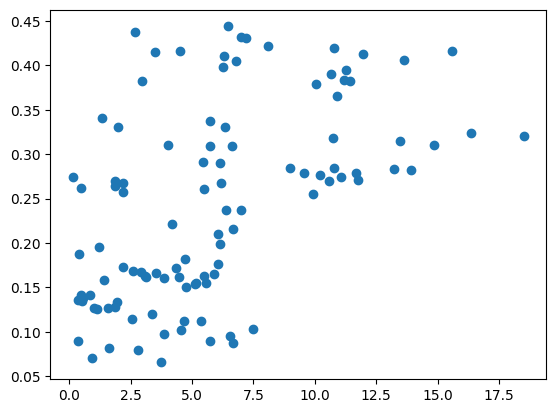

In [6]:
plt.scatter(df_base["MagGap"], df_base["DiffP"])

In [6]:
def plot_scatter(df, x_col, y_col, r_cols=None, groupby=None, hue_col="Dataset", annotate_modelpairs=False, model_short_form=None, title=None):
    plt.figure(figsize=(12, 8))
    
    # Add regression lines & R²
    
    r2_dict = {}
    if groupby:
        sum = 0
        for label in df[hue_col].unique():
            label_df = df[df[hue_col] == label]
            if len(label_df) < 2:
                continue  # Can't fit a line if less than 2 points
            if r_cols is not None:
                X = label_df[r_cols]
                y = label_df[y_col]
                reg = LinearRegression().fit(X, y)
                label_df[y_col] = label_df[y_col] - reg.predict(X)
                df.loc[df[hue_col] == label, 'Residual'] = label_df[y_col]
                
            sns.regplot(data=label_df, x=x_col, y=y_col, scatter=False, ci=None, line_kws={'linestyle': '--'})
            
            X = label_df[x_col].values.reshape(-1, 1)
            Y = label_df[y_col].values
            reg = LinearRegression().fit(X, Y)
            r2 = reg.score(X, Y)
            correlation = 'Positive' if reg.coef_[0] > 0 else 'Negative' if reg.coef_[0] < 0 else 'Zero'
            r2_dict[label] = f"{correlation} (R²={r2:.2f})"
            sign = 1 if reg.coef_[0] > 0 else -1
            sum += sign * r2
        print(f"Average r2: {sum/len(r2_dict)}")

    else:
        sns.regplot(data=df, x=x_col, y=y_col, scatter=False, ci=None, line_kws={'linestyle': '--'})
        
        X = df[x_col].values.reshape(-1, 1)
        Y = df[y_col].values
        reg = LinearRegression().fit(X, Y)
        r2 = reg.score(X, Y)
        correlation = 'Positive' if reg.coef_[0] > 0 else 'Negative' if reg.coef_[0] < 0 else 'Zero'
        r2_dict[hue_col] = f"{correlation} (R²={r2:.2f})"
        print(r2)
        
    if r_cols is not None:
        scatter = sns.scatterplot(
        data=df,
        x=x_col,
        y='Residual',
        hue=hue_col,
        palette='tab10',
        s=100,
        alpha=0.8,
        edgecolor='w',
        linewidth=0.5
    )

    else:
        scatter = sns.scatterplot(
            data=df,
            x=x_col,
            y=y_col,
            hue=hue_col,
            palette='tab10',
            s=100,
            alpha=0.8,
            edgecolor='w',
            linewidth=0.5
        )
    
    
    # Annotate model pairs if requested
    if annotate_modelpairs and model_short_form is not None:
        for _, row in df.iterrows():
            weak_short = model_short_form.get(row['WeakModel'], row['WeakModel'])
            strong_short = model_short_form.get(row['StrongModel'], row['StrongModel'])
            annotation = f"{weak_short}_{strong_short}"
            plt.text(
                row[x_col],
                row[y_col] + 0.1,
                annotation,
                fontsize=9,
                ha='center',
                va='bottom'
            )
    
    # Update legend
    handles, labels = scatter.get_legend_handles_labels()
    new_labels = [f"{label}: {r2_dict.get(label, '')}" for label in labels]
    plt.legend(
        handles=handles,
        labels=new_labels,
        title=f'{hue_col} (with R²)',
        fontsize=10,
        title_fontsize=13,
        loc='best'
    )
    
    plt.xlabel(x_col, fontsize=14)
    plt.ylabel(y_col, fontsize=14)
    if title is not None:
        plt.title(title, fontsize=16)
    else:
        plt.title(f"{y_col} vs. {x_col}", fontsize=16)
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

0.5962806269784939


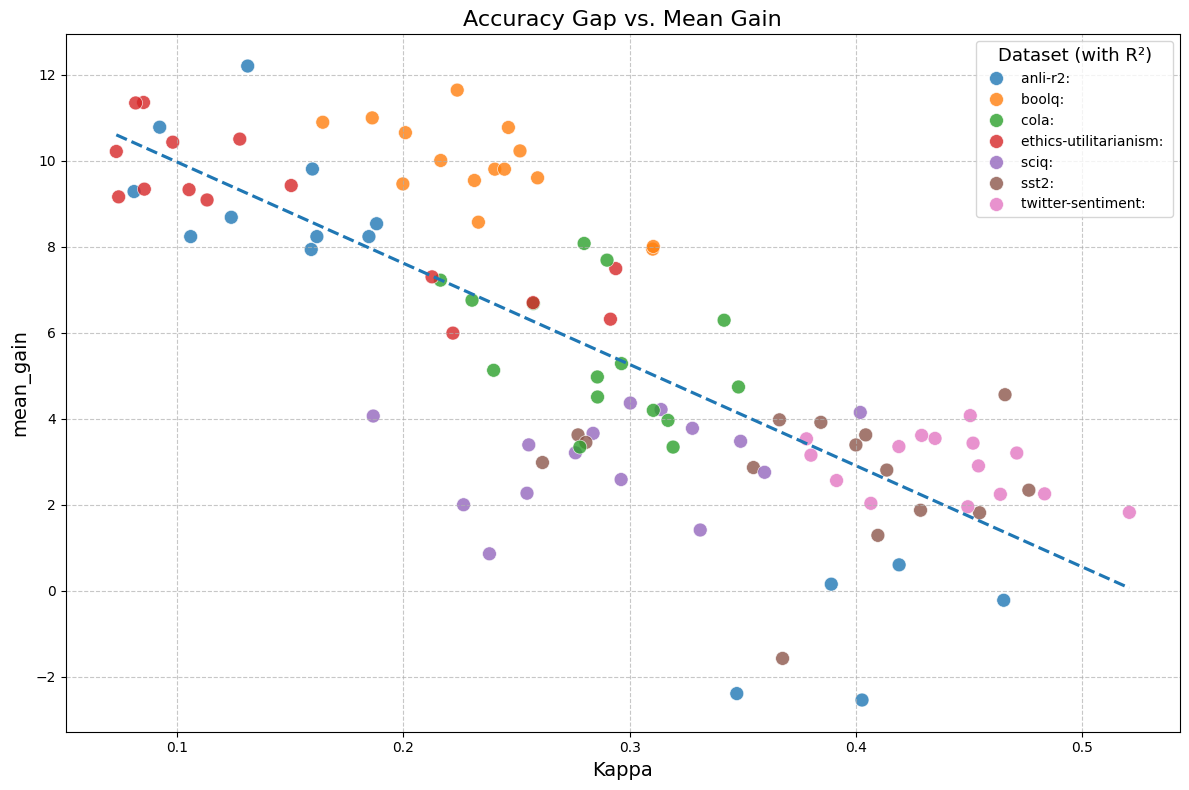

In [7]:
df_base['mean_gain'] = df_base['W2SAcc'] - (df_base['WeakFtAcc'] + df_base['StrongBaseAcc']) / 2
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='mean_gain',
    groupby=False,
    hue_col='Dataset',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Mean Gain"
)

/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

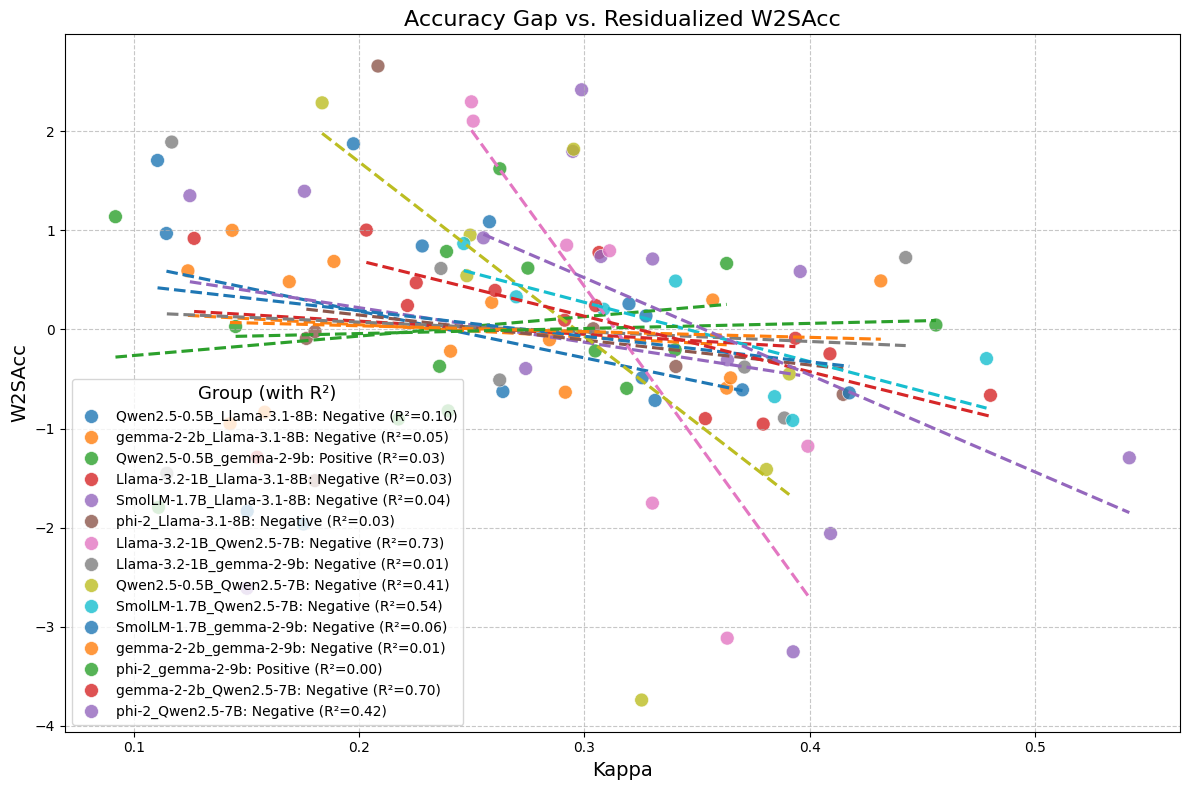

In [45]:
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SAcc',   # <-- use the residuals as y
    r_cols=['WeakFtAcc', 'StrongFtAcc'],  # <-- residuals are computed w.r.t these columns
    groupby=True,
    hue_col='Group',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)

/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

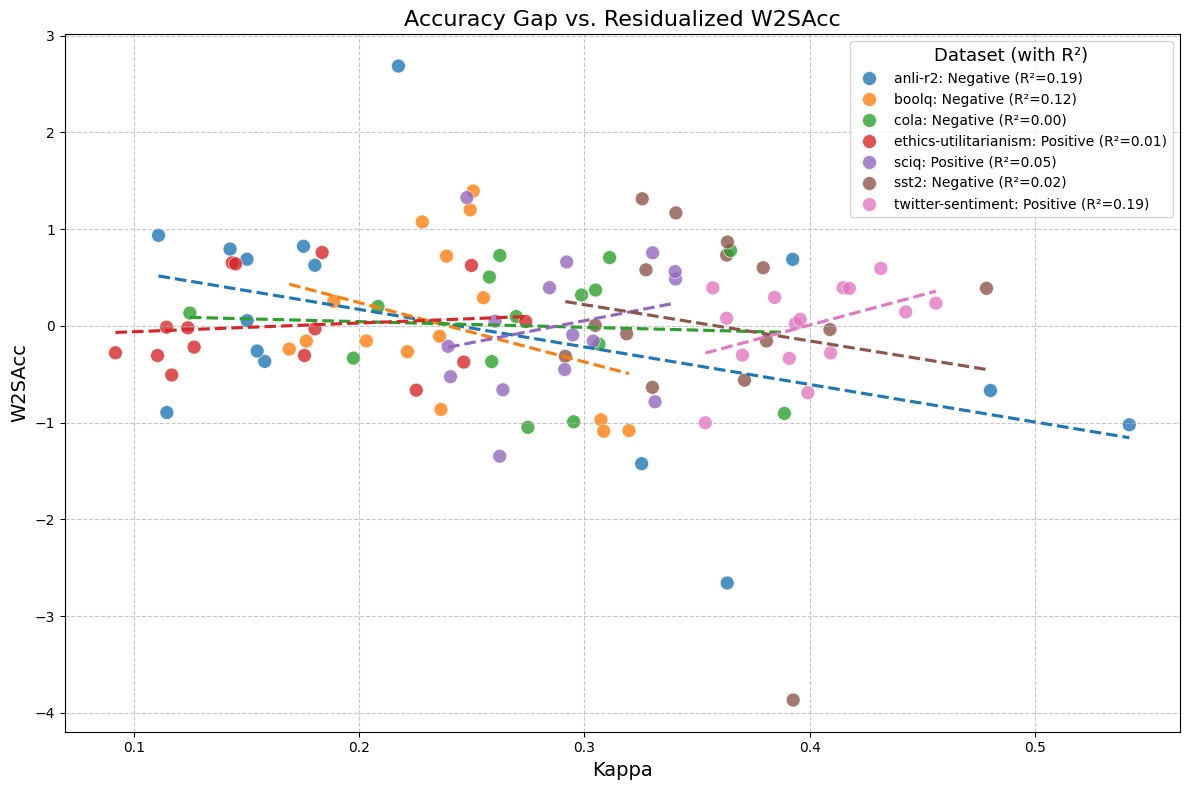

In [46]:
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SAcc',   # <-- use the residuals as y
    r_cols=['WeakFtAcc', 'StrongFtAcc'],  # <-- residuals are computed w.r.t these columns
    groupby=True,
    hue_col='Dataset',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)

/tmp/ipykernel_3270708/1954111663.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1954111663.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1954111663.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

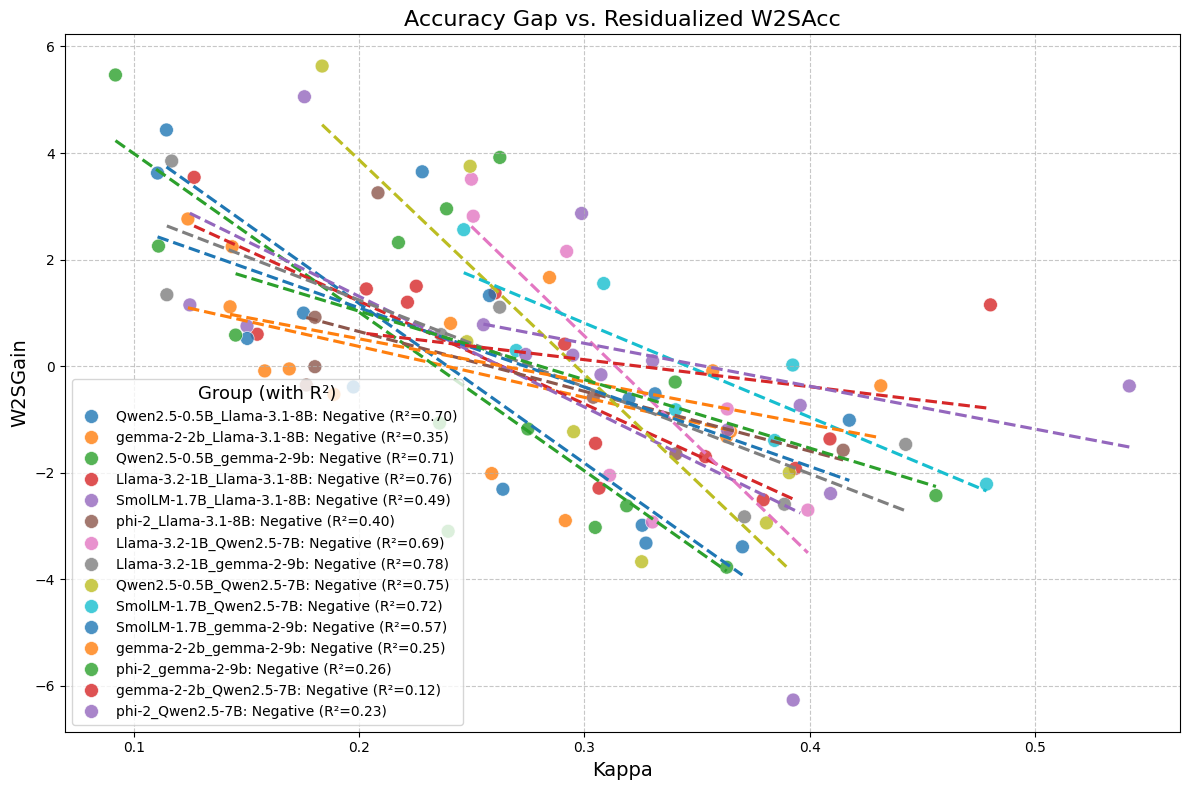

In [40]:
df_base['W2SGain'] = df_base['W2SAcc'] - df_base['WeakFtAcc']  # dependent variable
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']

# 4. Plot with your existing plot_scatter function
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SGain',   # <-- use the residuals as y
    r_cols=['AccGap'],
    groupby=True,
    hue_col='Group',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)

/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df[y_col] = label_df[y_col] - reg.predict(X)
/tmp/ipykernel_3270708/1983087617.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

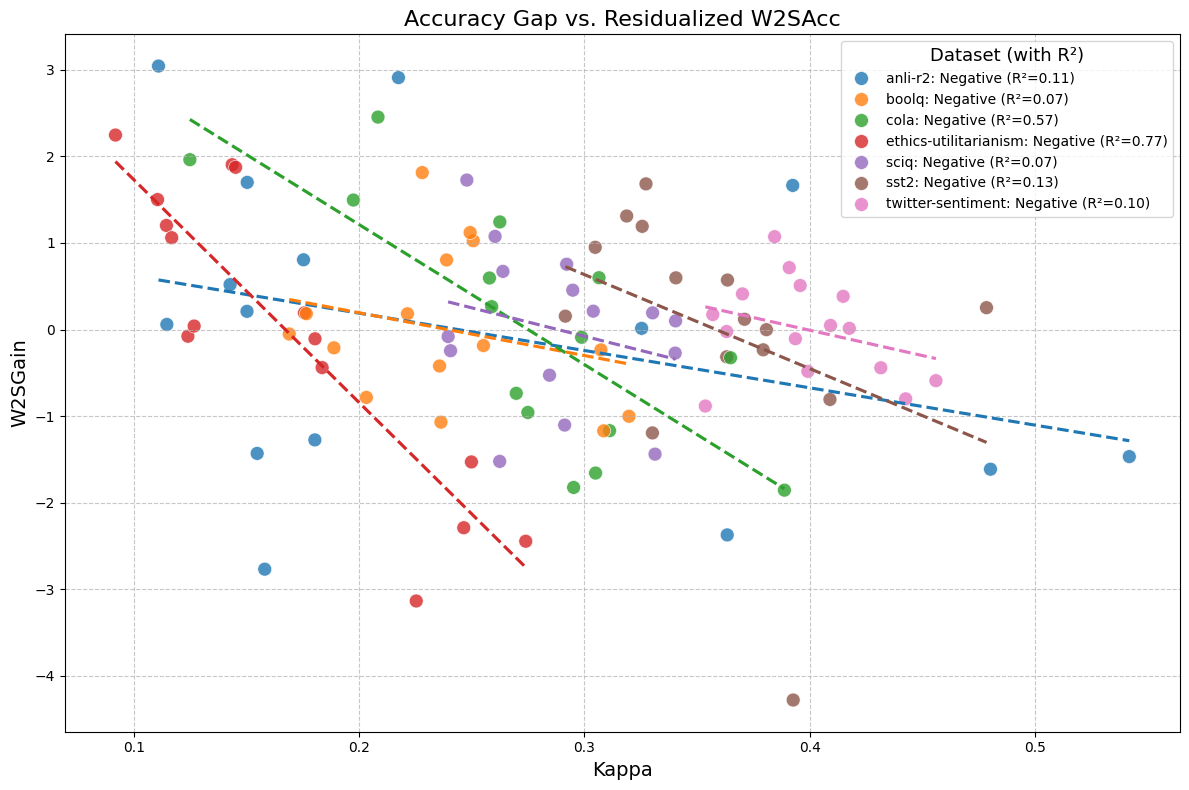

In [47]:
df_base['W2SGain'] = df_base['W2SAcc'] - df_base['WeakFtAcc']  # dependent variable
df_base['Group'] = df_base['WeakModel'] + '_' + df_base['StrongModel']

# 4. Plot with your existing plot_scatter function
plot_scatter(
    df_base,
    x_col='Kappa',
    y_col='W2SGain',   # <-- use the residuals as y
    r_cols=['AccGap'],
    groupby=True,
    hue_col='Dataset',
    annotate_modelpairs=False,
    model_short_form=model_short_form,
    title="Accuracy Gap vs. Residualized W2SAcc"
)